In [455]:
import tensorflow as tf
msg = tf.constant('Hello, TensorFlow!')
tf.print(msg)

Hello, TensorFlow!


In [456]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [457]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageEnhance
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import time
from numpy.core.numeric import False_ 
from astropy.visualization import make_lupton_rgb
from matplotlib import pyplot

print("GPU is","avaliable" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is avaliable


In [458]:
print("tensorflow version:",tf.__version__)
print("GPU is","avaliable" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

tensorflow version: 2.5.0
GPU is avaliable


In [459]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [460]:
print("GPU is","avaliable" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is avaliable


In [461]:
# %% [markdown]
# # Data pre-processing
#parameter about input feature
item = ["HR", "O2Sat", "Temp", "SBP", "MAP", "Resp"] 
bound = [[30, 200], 
         [80, 100], 
         [35, 39], 
         [60, 180], 
         [60, 130], 
         [10, 35] 
        ] 
lower_bound=0 
upper_bound=1

#parameter about how many window we want to cut in one person data
random_times=10

#neural network set
tmpData = []
tmpDataR = [] 
tmpDataG = [] 
tmpDataB = [] 
tmpLabel = []


#RGB g setup
r_mu=0.0
g_mu=128.0
b_mu=255.0
r_sigma=51.0
g_sigma=51.0
b_sigma=51.0

In [462]:

def rule(_label,check_begin,check_end,_window_size,_check_size):
    spesis=np.nanmean(_label)
    a=0
    if _label[0:_window_size-1].all()==0:
        check=dataframe["SepsisLabel"].iloc[check_begin:check_end].to_numpy()
        if np.nanmean(check)==0:
            # no sepsis : No sepsis across (window_size) hours period and next (check_size) hour
            outlabel= 0
        else:
            # pre-sepsis 1 : No sepsis across (window_size) hours period & sepsis in (window_size+1)~(window_size+check_size) hour
            outlabel=1
    elif np.nanmean(_label[0:5])==0 and _label[_window_size-1]==1:
#         pre-sepsis 2 : No sepsis across (window_size/2) hours period & sepsis in number (window_size) hour
        outlabel = 1
    if spesis>=(1/_window_size):
        # spesis : first hour and last hour are both spesis & total spesis time > 5
        outlabel = 2
    return outlabel

In [463]:
#  window               #check      #label
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1] 1
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 1 1] 1
# [0 0 0 0 0 0 0 0 0 0] [0 0 1 1 1] 1
# [0 0 0 0 0 0 0 0 0 0] [0 1 1 1 1] 1
# [0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1] 1
# [0 0 0 0 0 0 0 0 0  
# [0 0 0 0 0 1 1 1 1 1] [1 1 1 1 1] 2
# [0 0 0 0 1 1 1 1 1 1] [1 1 1 1] 2
# [0 0 0 1 1 1 1 1 1 1] [1 1 1] 2
# [0 0 1 1 1 1 1 1 1 1] [1 1] 2
# [0 1 1 1 1 1 1 1 1 1] [1] 2

In [464]:
def gus(x,mu,sigma):
    return math.exp(-((x-mu)*(x-mu))/(2*(sigma)*(sigma)))

In [465]:
# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-06-27T14:51:17.189751Z","iopub.execute_input":"2021-06-27T14:51:17.190388Z","iopub.status.idle":"2021-06-27T14:53:59.332797Z","shell.execute_reply.started":"2021-06-27T14:51:17.190334Z","shell.execute_reply":"2021-06-27T14:53:59.332019Z"}}
tStart = time.time()
for file in range(1, 100):
    #Read data
    #training_set data filename
    num = "%06d" % file
    filename = "p"+num
    ##training_setB data filename
    #num=100000+i
    #filename = "p"+str(num)
    try:
        dataframe = pd.read_csv("./training/"+filename+".psv", skiprows=0, sep='|') 
        window_size=10
        check_size=5
        #Random cut method
        index=0
        for sample_time in range(random_times):
            leng = len(dataframe)-window_size
            up = random.randint(1, leng)
            
            #setup label 
            label = dataframe["SepsisLabel"].iloc[up:up+window_size].to_numpy()   
            a=rule(label,up+window_size,up+window_size+check_size,window_size,check_size)
            if random.randint(0,20)<=10:
                continue
            classify=rule(label,sample_time+window_size,sample_time+window_size+check_size,window_size,check_size)
            for a in range(4):
                tmpLabel.append(classify)
                    
            #fill nan value and make dataframe(actually is numpy array)
            data= np.empty((window_size))
            rdata= np.empty((window_size))
            gdata= np.empty((window_size))
            bdata= np.empty((window_size))
            for items in range(len(item)):
                dataFromDF = dataframe[item[items]].drop(index=0).fillna(method='ffill').fillna(method='bfill')
                dataFromDF = dataFromDF.iloc[up-1:up+window_size-1] #??????
                dataFromDF = np.array((dataFromDF - bound[items][lower_bound])/(bound[items][upper_bound] - bound[items][lower_bound]))
                R_dataFromDF = 255*np.exp(-((255*dataFromDF-r_mu)*(255*dataFromDF-r_mu))/(2*(r_sigma)*(r_sigma)))  
                G_dataFromDF = 255*np.exp(-((255*dataFromDF-g_mu)*(255*dataFromDF-g_mu))/(2*(r_sigma)*(g_sigma)))  
                B_dataFromDF = 255*np.exp(-((255*dataFromDF-b_mu)*(255*dataFromDF-b_mu))/(2*(r_sigma)*(b_sigma)))  
                if items==0:
                    data=dataFromDF
                    rdata=R_dataFromDF
                    gdata=G_dataFromDF
                    bdata=B_dataFromDF
                else:
                    data=np.vstack([data,dataFromDF])
                    rdata=np.vstack([rdata,R_dataFromDF])
                    gdata=np.vstack([gdata,G_dataFromDF])
                    bdata=np.vstack([bdata,B_dataFromDF])
            
            #Change to graph and enhance it, than save feature graph to training set
            data *= 255  # 变换为0-255的灰度值
            image = Image.fromarray(make_lupton_rgb(rdata.T, gdata.T, bdata.T, stretch=0.5)).resize((128,128))
#             plt.imshow(image)
            #R channel
            im_R = Image.fromarray(rdata.T).convert('L').resize((128,128))
            tmpData.append(np.array(im_R))
            #G channel
            im_G = Image.fromarray(gdata.T).convert('L').resize((128,128))
            tmpData.append(np.array(im_R))
            #B channel
            im_B = Image.fromarray(bdata.T).convert('L').resize((128,128))
            tmpData.append(np.array(im_B))
            #Gray channel
            im = Image.fromarray(data.T).convert('L') # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
            im = ImageEnhance.Contrast(im).enhance(5.5).resize((128,128))#ImageEnhance.Contrast(im).enhance(0)
            tmpData.append(np.array(im))
    except:
        continue
   
tEnd = time.time()

print(f"\nData processing complete in {tEnd - tStart} seconds.\n")


Data processing complete in 2.5931453704833984 seconds.



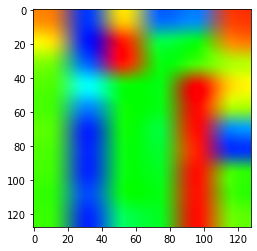

In [466]:
plt.imshow(image)

0


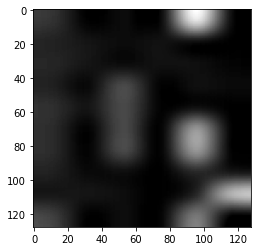

In [467]:
for num in range(len(tmpLabel)):
    if tmpLabel[num]==0:
        plt.imshow(tmpData[num], cmap='gray')
        print(tmpLabel[num])
        break

1


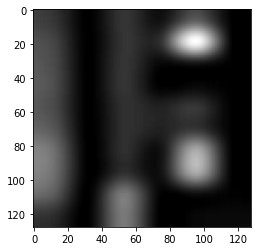

In [468]:
# how feature graph look like
for num in range(len(tmpLabel)):
    if tmpLabel[num]==1:
        plt.imshow(tmpData[num], cmap='gray')
        print(tmpLabel[num])
        break

2


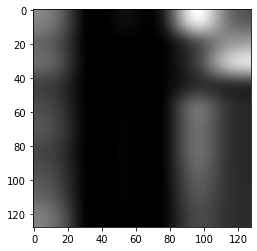

In [469]:
# how feature graph look like
for num in range(len(tmpLabel)):
    if tmpLabel[num]==2:
        plt.imshow(tmpData[num], cmap='gray')
        print(tmpLabel[num])
        break

In [470]:
#Number of each category
numofclass0=0
numofclass1=0
numofclass2=0
for num in range(len(tmpLabel)):
    if tmpLabel[num]==0:
        numofclass0+=1
    elif tmpLabel[num]==1:
        numofclass1+=1
    elif tmpLabel[num]==2:
        numofclass2+=1
print(numofclass0,"->",numofclass0/len(tmpLabel))
print(numofclass1,"->",numofclass1/len(tmpLabel))
print(numofclass2,"->",numofclass2/len(tmpLabel))

1668 -> 0.86875
112 -> 0.058333333333333334
140 -> 0.07291666666666667


In [475]:
tStart = time.time()

# shuffle, seed = 6
random.Random(6).shuffle(tmpData)
random.Random(6).shuffle(tmpLabel)

print("Shuffle complete.")

tmpData = np.array(tmpData)
tmpLabel = np.array(tmpLabel)

print("Transfer complete.")

trainingData, validData, trainingLabel1, validLabel1 = train_test_split(tmpData, tmpLabel, test_size=0.125)

print("Split data complete.")

trainingLabel=[]
validLabel=[]
for i in range(len(trainingLabel1)):
    if i%4==0:
        trainingLabel.append(trainingLabel1[i])
trainingLabel= np.array(trainingLabel)
for i in range(len(validLabel1)):
    if i%4==0:
        validLabel.append(validLabel1[i])
validLabel= np.array(validLabel)

trainingData = trainingData.reshape(int(len(trainingData)/4), 128,128, 4)
trainingLabel = trainingLabel.reshape(len(trainingLabel), 1)
# print(trainingData)
validData = validData.reshape(int(len(validData)/4), 128,128, 4)
validLabel = validLabel.reshape(len(validLabel), 1)

print("Reshape data complete.")

trainingLabelOneHot = np_utils.to_categorical(trainingLabel) # One-Hot encoding label
validLabelOneHot = np_utils.to_categorical(validLabel)

tEnd = time.time()

print(f"\nPrepare training data complete in {tEnd - tStart} seconds.\n")

Shuffle complete.
Transfer complete.
Split data complete.
Reshape data complete.

Prepare training data complete in 0.03696441650390625 seconds.



In [476]:
from keras import backend as K
K.image_data_format() == "channels_first"

tStart = time.time()

model = Sequential()

model.add(Conv2D(filters=36, kernel_size=(9, 9), activation='relu', input_shape=(128,128, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=36, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation = 'relu'))
model.add(Dense(units=3, activation = 'softmax')) # 3 labels

model.summary()

# sgd = Adam(lr=0.0005)

model.compile(loss = 'categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

tEnd = time.time()

print(f"\nBuild model complete in {tEnd - tStart} seconds.\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 36)      11700     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 36)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 36)        32436     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 36)        11700     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 36)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 36)        0

In [477]:
# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-06-27T14:54:00.001214Z","iopub.execute_input":"2021-06-27T14:54:00.001530Z","iopub.status.idle":"2021-06-27T14:54:00.759721Z","shell.execute_reply.started":"2021-06-27T14:54:00.001500Z","shell.execute_reply":"2021-06-27T14:54:00.758520Z"}}
def validDataGenerator(data, label, batch_size):
    
    # 分批載入資料，每批數量為batch_size
    
    i = 0
    
    while (True):
        
        yield data[i*batch_size : (i+1)*batch_size], label[i*batch_size : (i+1)*batch_size]
        
        if(i < len(label)//batch_size):
            i += 1
        else:
            i = 0

trainingDataGenerator = ImageDataGenerator(
#                             rotation_range=15,
#                             height_shif t_range=0.1,
#                             width_shift_range=0.05,
#                             horizontal_flip=True,
#                             vertical_flip=True,
#                             zoom_range=0.1,
                            data_format='channels_last'
)

trainingDataGenerator.fit(trainingData)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-06-27T14:54:00.762312Z","iopub.execute_input":"2021-06-27T14:54:00.762631Z"}}
tStart = time.time()

batch_size = 128
epochs = 50

reduce_lr_from_loss = ReduceLROnPlateau(
#     factor = 0.95,
    factor = 0.7,
    monitor = 'val_loss',
    min_lr = 1e-6,
    patience = 4,
    verbose = 1,
)

reduce_lr_from_acc = ReduceLROnPlateau(
#     factor = 0.98,
    factor = 0.8,
    monitor = 'val_accuracy',
    min_lr = 1e-6,
    patience = 4,
    verbose = 1,
)

train_history = model.fit_generator(trainingDataGenerator.flow(trainingData, trainingLabelOneHot, batch_size),
    steps_per_epoch=len(trainingLabelOneHot)//batch_size,
    epochs=epochs,
    validation_data=validDataGenerator(validData, validLabelOneHot, batch_size),
    validation_steps=len(validLabelOneHot)//batch_size,
    verbose=1,
    callbacks=[reduce_lr_from_loss, reduce_lr_from_acc],
#     initial_epoch=75
)

tEnd = time.time()

print(f"\nTrain model complete in {tEnd - tStart} seconds.\n")

MemoryError: Unable to allocate 105. MiB for an array with shape (420, 128, 128, 4) and data type float32

In [ ]:
# %% [code] {"jupyter":{"outputs_hidden":false}}
plt.figure(figsize=(30, 6))

plt.subplot(1, 2, 1)
plt.plot(train_history.history['accuracy'], label="accuracy")
plt.plot(train_history.history['val_accuracy'], 'orange', label="val_accuracy")
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

# plt.subplot(1, 3, 2)
# plt.plot(train_history.history['loss'], label="loss")
# plt.plot( plt.xlabel('Epoch')
# plt.ylabel('loss')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_history.history['lr'], 'orange')
plt.xlabel('Epoch')
plt.ylabel('learning_rate')

# plt.savefig("DefectDetecting-2.png")
plt.show()

# %% [code] {"jupyter":{"outputs_hidden":false}}
model.save('/kaggle/working/spesis-class3-v1.h5')
print("save done")

# %% [code] {"jupyter":{"outputs_hidden":false}}
import pandas as pd

prediction = model.predict_classes(validData)

pd.crosstab(validLabel.reshape(len(validLabel)), prediction, rownames=['label'], colnames=['predict'])